In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
import seaborn as sns
import sqlite3

In [2]:
!python --version

Python 2.7.14


## Loading the data
    
We are importing the data from remote database and we are using Impala connectors to establish the connect.
<br>
The size of total data is more than 20 Million rows, but to make it simple for this sample project model has been trained on only 50K rows.

In [3]:
# import os
# import pandas
# import impala
# from impala.dbapi import connect
# from impala.util import as_pandas

# # Specify HIVE_HMS_HOST as an environment variable in your project settings
# HIVE_HMS_HOST = os.getenv('HIVE_HMS_HOST', '192.168.208.128')

# # This connection string depends on your cluster setup and authentication mechanism
# conn = connect(host=HIVE_HMS_HOST,
#                port='10000',
#                auth_mechanism='PLAIN',
#                user='cloudera', password='cloudera', database='cdsdq' )
# cursor = conn.cursor()
# cursor.execute("select * from retailer_missing")
# tables = as_pandas(cursor)


In [4]:
# import sys
# data = tables
# sys.getsizeof(data)

In [5]:
## remove this from original
import pandas as pd

data = pd.read_csv('D:\Python27\CDSDQ Final Assignments\sqlite_impala_missing.csv')
data.head(2)

,Index,Sale_date,weekday_name,product,assessment,month,weekno,store_number,volume,turnover,turnover_missing
0,169949,4/7/2017 0:00,Friday,CREST B+S 2PACK 75ML,Right Data,4,14,2732,2,48.10,48.10
1,169950,4/7/2017 0:00,Friday,CREST B+S 2PACK 75ML,Right Data,4,14,2768,6,149.46,149.46


In [6]:
data.columns = ['Index','Sale_date','weekday_name','product','assessment','month','weekno','store_number','volume','turnover','turnover_missing']
print(data.columns)

Index([u'Index', u'Sale_date', u'weekday_name', u'product', u'assessment',
       u'month', u'weekno', u'store_number', u'volume', u'turnover',
       u'turnover_missing'],
      dtype='object')


In [7]:
data = data[['Sale_date','weekday_name','product','assessment','month','weekno','store_number','volume','turnover','turnover_missing']]

In [8]:
first_set = data

In [9]:
import warnings
warnings.filterwarnings("ignore")

first_set.volume = first_set.volume.astype(float)
first_set.turnover = first_set.turnover.astype(float)
first_set.turnover_missing = first_set.turnover_missing.astype(float)
first_set.weekno = first_set.weekno.astype(int)
first_set.month = first_set.month.astype(int)
first_set.store_number = first_set.store_number.astype(int)
first_set['Sale_date'] =  pd.to_datetime(first_set['Sale_date'])
first_set['product'] = pd.DataFrame(first_set['product'])


In [10]:
first_set.head()

,Sale_date,weekday_name,product,assessment,month,weekno,store_number,volume,turnover,turnover_missing
0,2017-04-07,Friday,CREST B+S 2PACK 75ML,Right Data,4,14,2732,2.0,48.10,48.10
1,2017-04-07,Friday,CREST B+S 2PACK 75ML,Right Data,4,14,2768,6.0,149.46,149.46
2,2017-04-07,Friday,CREST B+S 2PACK 75ML,Right Data,4,14,2839,3.0,72.15,72.15
3,2017-04-07,Friday,CREST B+S 2PACK 75ML,Right Data,4,14,2840,3.0,72.15,72.15
4,2017-04-07,Friday,CREST B+S 2PACK 75ML,Right Data,4,14,2947,4.0,96.20,96.20


## Creating another column to Assessment to categorize the data based on the guidelines

data has been categorized into "Right Data", "Missing Data" and "Invalid Data" <br>
we will consider the right data and run our model to check how accurate are the predictions

In [11]:
import warnings
warnings.filterwarnings('ignore')
import math
def variable(row):
    x = row['volume']
    y = row['turnover_missing']
#     print(x,y, type(x), type(y), math.isnan(y))
    if ((x==0) & (y==0)):
        return 'Right Data'
    if ((x>0) & (y>0)):
        return 'Right Data'
    if ((x<0) & (y<0)):
        return 'Right Data'
    if ((x!=0) & (math.isnan(y))):
        return 'Missing Data'
    if ((x==0) & (math.isnan(y))):
        return 'Missing Data'
    if ((math.isnan(x)) & (y!=0)):
        return 'Missing Data'
    return 'Invalid Data'
    
first_set['Assessment'] = first_set.apply(variable, axis=1)

### Checking for Null values in the Volume 

In [12]:
sample_V = first_set[first_set['volume']!=0]
sample2_V = sample_V[sample_V['volume'].notnull()]
print('Null Values in Volume:', sample2_V.volume.isnull().sum())
print('-----')
# Shape of the total data set and Dataset after removing zeros from Volume.
print(first_set.shape)
print(sample2_V.shape)

('Null Values in Volume:', 0)
-----
(58836, 11)
(58836, 11)


Plotting the Distribution of turnover data

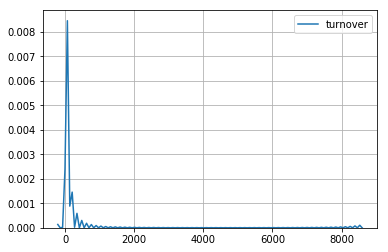

In [13]:
%matplotlib inline

# sns.FacetGrid(sample2_V, size=4).map(sns.distplot, 'volume')
sns.kdeplot(sample2_V.turnover)
plt.grid()

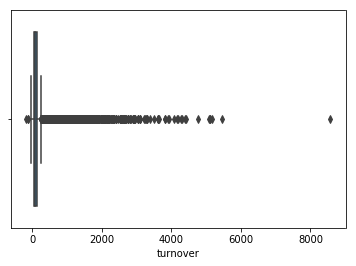

In [14]:
sns.boxplot(sample2_V.turnover)

In [15]:
second_set = first_set

In [16]:
second_set.describe()

,month,weekno,store_number,volume,turnover,turnover_missing
count,58836.0,58836.000000,58836.000000,58836.000000,58836.000000,58816.000000
mean,4.0,15.776837,2926.835016,4.238205,121.309352,121.320219
std,0.0,1.461136,1239.128888,11.273705,216.870703,216.904153
min,4.0,14.000000,58.000000,-2.000000,-187.940000,-187.940000
25%,4.0,15.000000,1892.000000,1.000000,34.400000,34.400000
50%,4.0,16.000000,3016.000000,2.000000,63.800000,63.800000
75%,4.0,17.000000,3807.000000,4.000000,124.140000,124.140000
max,4.0,18.000000,5855.000000,553.000000,8570.640000,8570.640000


Applying Transformations to reduce the Skewness in data

In [17]:
from pynverse import inversefunc
cube = (lambda n: n**3)
invcube = inversefunc(cube, second_set['turnover_missing'])
second_set['Inv_Cubic'] = invcube

In [18]:
print(first_set.turnover_missing.skew())
print(second_set['Inv_Cubic'].skew())

8.417318692610143
1.8753148541925788


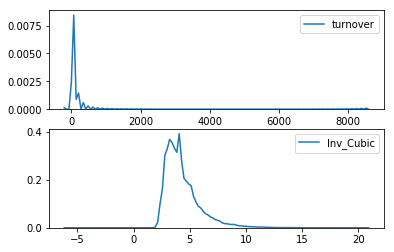

In [19]:
plt.subplot(211)
sns.kdeplot(second_set.turnover)

plt.subplot(212)
sns.kdeplot(second_set['Inv_Cubic'])

In [20]:
second_set.describe()

,month,weekno,store_number,volume,turnover,turnover_missing,Inv_Cubic
count,58836.0,58836.000000,58836.000000,58836.000000,58836.000000,58816.000000,58836.000000
mean,4.0,15.776837,2926.835016,4.238205,121.309352,121.320219,4.331135
std,0.0,1.461136,1239.128888,11.273705,216.870703,216.904153,1.583730
min,4.0,14.000000,58.000000,-2.000000,-187.940000,-187.940000,-5.728045
25%,4.0,15.000000,1892.000000,1.000000,34.400000,34.400000,3.252267
50%,4.0,16.000000,3016.000000,2.000000,63.800000,63.800000,3.995829
75%,4.0,17.000000,3807.000000,4.000000,124.140000,124.140000,4.988507
max,4.0,18.000000,5855.000000,553.000000,8570.640000,8570.640000,20.464655


In [21]:
# second_set.head()
# # print(min(sample2_V.turnover))

To Vectorize the Categorical data before we proceed to apply <b>OneHotEncoding</b> I have cleansed the data by removing the spaces <br>
data shown below removing the spaces

In [22]:
second_set['product'].head(3)

0    CREST B+S 2PACK 75ML
1    CREST B+S 2PACK 75ML
2    CREST B+S 2PACK 75ML
Name: product, dtype: object

In [23]:
third_set = second_set['product'].str.replace(' ','_')

In [24]:
third_set.head()

0    CREST_B+S_2PACK_75ML
1    CREST_B+S_2PACK_75ML
2    CREST_B+S_2PACK_75ML
3    CREST_B+S_2PACK_75ML
4    CREST_B+S_2PACK_75ML
Name: product, dtype: object

In [25]:
third_set['product'] = third_set

In [26]:
second_set['product'] = third_set['product']

In [27]:
second_set.columns

Index([u'Sale_date', u'weekday_name', u'product', u'assessment', u'month',
       u'weekno', u'store_number', u'volume', u'turnover', u'turnover_missing',
       u'Assessment', u'Inv_Cubic'],
      dtype='object')

In [28]:
second_set = second_set[['Sale_date','product','Assessment','weekno','store_number','volume','turnover','turnover_missing','Inv_Cubic']]
len(second_set.columns)

9

In [29]:
# Outliers, Invalid Data was removed from this "Second_set" dataset.
# Printing the shapes of Second_set_positive, second_set_negative for reference

# second_set_right = second_set[second_set.Assessment=='Right Data']
# print(second_set_right.shape)

# Finding (Right Data) in Turnover column
second_set_Right = second_set[second_set['Assessment']=='Right Data']
print(second_set_Right.shape)

# # Finding (Missing Data) values in Turnover column 
second_set_Missing = second_set[second_set['Assessment']=='Missing Data']
print(second_set_Missing.shape)

(58816, 9)
(20, 9)


## Vectorizing the Product Name

In [30]:
fourth_set = second_set

In [31]:
fourth_set.columns

Index([u'Sale_date', u'product', u'Assessment', u'weekno', u'store_number',
       u'volume', u'turnover', u'turnover_missing', u'Inv_Cubic'],
      dtype='object')

In [32]:
fourth_set.shape

(58836, 9)

In [33]:
# Vectorizing on the "Products" of second_set (contains no outliers and Invalid data)

from sklearn.feature_extraction.text import CountVectorizer
OHE = CountVectorizer()
fourth_set1 = OHE.fit_transform(second_set['product'])
fourth_set2 = second_set['store_number'].values.reshape(-1,1)
fourth_set3 = second_set['weekno'].values.reshape(-1,1)
# fourth_set4 = second_set['Store'].reshape(-1,1)
fourth_set4 = second_set['volume'].values.reshape(-1,1)


In [34]:
print fourth_set1.shape, fourth_set2.shape, fourth_set3.shape, fourth_set4.shape

(58836, 586) (58836L, 1L) (58836L, 1L) (58836L, 1L)


In [35]:
# Applying One Hot Encoding on the "Products" of  Second_set.

from sklearn import preprocessing

# limit to categorical data using df.select_dtypes()
Onehot = second_set[['Sale_date','product','weekno','store_number','volume','turnover','turnover_missing','Inv_Cubic']]
# Onehot.columns
X = Onehot.select_dtypes(include=[object])
X.head(3)

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()
# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
X_2 = X.apply(le.fit_transform)
X_2.head()
enc = preprocessing.OneHotEncoder()
enc.fit(X_2)
fourth_set1 = enc.transform(X_2)
fourth_set1.dtype

dtype('float64')

<p><b>Training Dataset</b></p>

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
Train_Products = fourth_set1[np.where(second_set['Assessment']=='Right Data')]
Train_store_number = fourth_set2[np.where(second_set['Assessment']=='Right Data')]
Train_weekno = fourth_set3[np.where(second_set['Assessment']=='Right Data')]
# Train_Store = fourth_set4[np.where(second_set['Assessment']=='Right Data')]
Train_Volume = fourth_set4[np.where(second_set['Assessment']=='Right Data')]


In [38]:
from scipy.sparse import hstack
Train_X = hstack((Train_Products, Train_store_number, Train_weekno, Train_Volume))
Train_Y = second_set_Right.Inv_Cubic

print(Train_X.shape)
print(Train_Y.shape)

(58816, 578)
(58816L,)


<p><b> Test Dataset </b></p>

In [39]:
Test_Products = fourth_set1[np.where(second_set['Assessment']=='Missing Data')]
Test_weekday = fourth_set2[np.where(second_set['Assessment']=='Missing Data')]
Test_weekno = fourth_set3[np.where(second_set['Assessment']=='Missing Data')]
Test_Volume = fourth_set4[np.where(second_set['Assessment']=='Missing Data')]

In [40]:
from scipy.sparse import hstack
Test_X = hstack((Test_Products, Test_weekday, Test_weekno, Test_Volume))
Test_Y = second_set_Missing.turnover_missing


In [41]:
print(Test_X.shape)
print(Test_Y.shape)
print '='*50

(20, 578)
(20L,)


In [42]:
print Train_X.shape
print Train_Y.shape
print Test_X.shape
print Test_Y.shape

(58816, 578)
(58816L,)
(20, 578)
(20L,)


In [43]:
Train_X = Train_X.tocsr()
Test_X = Test_X.tocsr()

In [44]:
T_X = Train_X[0:50000]
T_Y = Train_Y[:50000]
Val_X = Train_X[50000:]
Val_Y = Train_Y[50000:]

In [45]:
print T_X.shape, T_Y.shape, Val_X.shape, Val_Y.shape

(50000, 578) (50000L,) (8816, 578) (8816L,)


XGb model 

In [76]:
from xgboost.sklearn import XGBRegressor
# params = {'learning_rate' : 0.1,'n_estimators' : 400,'max_depth' : 5,'min_child_weight' : 4,'gamma' : 0.2,'reg_lambda' : 0,'booster' : 'gbtree' ,'subsample' : 0.9,'reg_alpha' : 0.001,'colsample_bytree' : 0.9,'n_jobs' : -1,'silent' : True,'scale_pos_weight' : 1}
model = XGBRegressor()
model.fit(T_X, T_Y)
pred = model.predict(Val_X)
train_accuracy = round(model.score(T_X, T_Y) * 100, 2)
validation_accuracy = round(model.score(Val_X, Val_Y) * 100, 2)
print "train accuracy for XGB:", train_accuracy
print "Validation accuracy for XGB:", validation_accuracy

train accuracy for XGB: 81.98
Validation accuracy for XGB: 81.06


KNN model

In [79]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 3)
knn.fit(T_X, T_Y)
knn_pred = knn.predict(Val_X)
knn_train_accuracy = round(knn.score(T_X, T_Y) * 100, 2)
knn_validation_accuracy = round(knn.score(Val_X, Val_Y) * 100, 2)

print "train accuracy for KNN:", knn_train_accuracy
print "Validation accuracy for KNN:", knn_validation_accuracy

train accuracy for KNN: 81.85
Validation accuracy for KNN: 63.06


Random Forest Model

In [82]:
from sklearn.ensemble import RandomForestRegressor
start_time = datetime.datetime.now()
random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(T_X, T_Y)
RF_train_accuracy = round(random_forest.score(T_X, T_Y) * 100, 2)
RF_validation_accuracy = round(random_forest.score(Val_X, Val_Y) * 100, 2)

print "train accuracy for RF:", RF_train_accuracy
print "Validation accuracy for RF:", RF_validation_accuracy
end_time = datetime.datetime.now()
print "time taken for execution %d" %(end_time-start_time).seconds

train accuracy for RF: 99.63
Validation accuracy for RF: 95.91
time taken for execution 605


Linear Model

In [84]:
from sklearn.linear_model import LinearRegression
Linear = LinearRegression()
Linear.fit(T_X, T_Y)
Linear_train_accuracy = round(Linear.score(T_X, T_Y) * 100, 2)
Linear_validation_accuracy = round(Linear.score(Val_X, Val_Y) * 100, 2)

print "train accuracy for LR:", Linear_train_accuracy
print "Validation accuracy for LR:", Linear_validation_accuracy

train accuracy for LR: 65.99
Validation accuracy for LR: 64.22


Hyperparameter Tuning for Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameter_grid = {
             'max_depth' : [4, 6, 8],
             'n_estimators': [10, 50,100],
             'max_features': ['sqrt', 'auto', 'log2'],
             'min_samples_split': [0.001,0.003,0.01],
             'min_samples_leaf': [1, 3, 10],
             'bootstrap': [True,False],
             }

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid.fit(T_X, T_Y)

print(grid.best_score_)
print(grid.best_params_)

Hyperparameter Tuning for XGB:

In [ ]:
param_test6 = {
 'n_estimators':[100, 200, 300, 400, 500, 600],
 'learning_rate':[0.0001, 0.001, 0.01, 0.1]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, n_jobs=4,iid=False, cv=5)
gsearch6.fit(Train_X,Train_Y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test1 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.7, n_estimators=1000, max_depth=5,
 min_child_weight=4, gamma=0.1, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1), 
 param_grid = param_test1,n_jobs=4,iid=False, cv=5)
gsearch1.fit(Train_X,Train_Y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.7, n_estimators=1000, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(Train_X ,Train_Y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.7, n_estimators=1000, max_depth=4,
 min_child_weight=4, gamma=0, subsample=0.9, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(Train_X,Train_Y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

In [ ]:
param_test6 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.7, n_estimators=1000, max_depth=4,
 min_child_weight=4, gamma=0.0, subsample=0.9, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, n_jobs=4,iid=False, cv=5)
gsearch6.fit(Train_X,Train_Y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [78]:
from sklearn.metrics import *
from math import sqrt
############    MAPE
    
print(np.mean(np.abs((Val_Y - pred) / Val_Y)) * 100)
    
###########     RMSE
    
mse = mean_squared_error(Val_Y, pred)
RMSE=sqrt(mse)
print("RMSE: %.2f" % RMSE)

###########     R2 Score

r2 = r2_score(Val_Y, pred)
print("r2: %.2f" % r2)

##########      MAE    
    
mae = mean_absolute_error(Val_Y, pred)
print('MAE: %f' % mae)
    

12.900418769410157
RMSE: 0.67
r2: 0.81
MAE: 0.525516


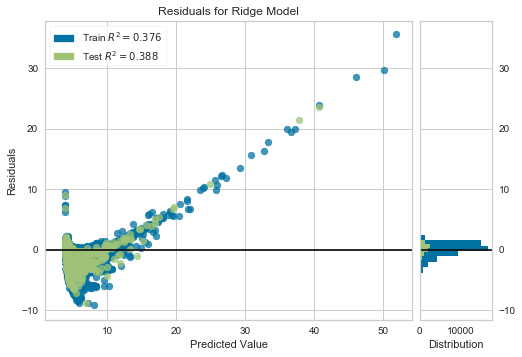

In [48]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)
visualizer.fit(T_X, T_Y)  # Fit the training data to the model
visualizer.score(Val_X, Val_Y)  # Evaluate the model on the test data
visualizer.poof() 

In [66]:
from sklearn.model_selection import *
import datetime
start_time  = datetime.datetime.now()


kf = 5

for i in range(kf):
    X_tr, X_cv, y_tr, y_cv = train_test_split(T_X, T_Y, test_size = 0.3)
    params = {'learning_rate' : 0.1,'n_estimators' : 400,'max_depth' : 5,'min_child_weight' : 4,'gamma' : 0.2,'reg_lambda' : 0,'booster' : 'gbtree' ,'subsample' : 0.9,'reg_alpha' : 0.001,'colsample_bytree' : 0.9,'n_jobs' : -1,'silent' : True,'scale_pos_weight' : 1}
    
    XGB = XGBRegressor(**params)
    XGB.fit(X_tr, y_tr)

    XGB_pred = XGB.predict(X_cv)

    
###########     RMSE
    
    mse = mean_squared_error(y_cv, XGB_pred)
    RMSE=sqrt(mse)
    print("RMSE: %.2f" % RMSE)

###########     R2 Score

    r2 = r2_score(y_cv, XGB_pred)
    print("r2: %.2f" % r2)

##########      MAE    
    
    mae = mean_absolute_error(y_cv, XGB_pred)
    print('MAE: %f' % mae)
end_time = datetime.datetime.now()
print ('Training Done..., Time Cost: %d' % ((end_time - start_time).seconds))

RMSE: 0.38
r2: 0.94
MAE: 0.292012
RMSE: 0.40
r2: 0.94
MAE: 0.290372
RMSE: 0.38
r2: 0.94
MAE: 0.294116
RMSE: 0.39
r2: 0.94
MAE: 0.294579
RMSE: 0.38
r2: 0.95
MAE: 0.292291
Training Done..., Time Cost: 21


In [70]:
# from sklearn.metrics import *
# from math import sqrt
# ############    MAPE
    
# print(np.mean(np.abs((Test_Y - pred) / Test_Y)) * 100)
    
# ###########     RMSE
    
# mse = mean_squared_error(Test_Y, pred)
# RMSE=sqrt(mse)
# print("RMSE: %.2f" % RMSE)

# ###########     R2 Score

# r2 = r2_score(Test_Y, pred)
# print("r2: %.2f" % r2)

# ##########      MAE    
    
# mae = mean_absolute_error(Test_Y, pred)
# print('MAE: %f' % mae)
    